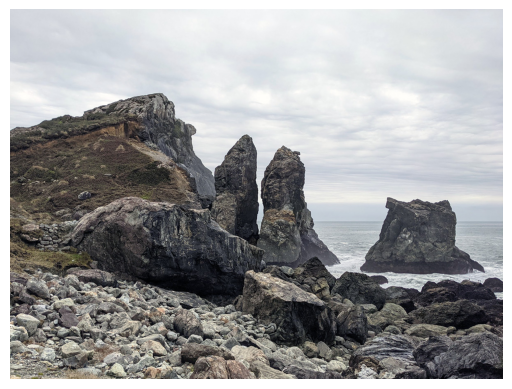

In [52]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file('./coast.jpg', 'https://img-datasets.s3.amazonaws.com/coast.jpg')

plt.axis('off')
plt.imshow(keras.utils.load_img(base_image_path))

In [53]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

layer_settings = {
    'mixed4': 1.0,
    'mixed5': 1.5, 
    'mixed6': 2.0,
    'mixed7': 2.5
}

outputs_dict = dict ([
    (layer.name, layer.output) for layer in [model.get_layer(name) for name in layer_settings.keys()]
])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [54]:
import tensorflow as tf

def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [55]:
@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    
    return loss, image

def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [56]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [57]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [58]:
original_image = preprocess_image(base_image_path)
original_shape = original_image.shape[1:3]

succesive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    succesive_shapes.append(shape)
    
succesive_shapes = succesive_shapes[::-1]

shrunk_original_image = tf.image.resize(original_image, succesive_shapes[0])

img = tf.identity(original_image)

In [59]:
for i, shape in enumerate(succesive_shapes):
    print(i, shape)
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_image, shape)
    same_size_original = tf.image.resize(original_image, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail 
    shrunk_original_image = tf.image.resize(original_image, shape)
    
keras.utils.save_img('dream.jpg', deprocess_image(img.numpy()))

0 (459, 612)
... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.43
... Loss value at step 3: 1.82
... Loss value at step 4: 2.16
... Loss value at step 5: 2.47
... Loss value at step 6: 2.84
... Loss value at step 7: 3.20
... Loss value at step 8: 3.58
... Loss value at step 9: 3.93
... Loss value at step 10: 4.29
... Loss value at step 11: 4.64
... Loss value at step 12: 5.03
... Loss value at step 13: 5.39
... Loss value at step 14: 5.76
... Loss value at step 15: 6.08
... Loss value at step 16: 6.45
... Loss value at step 17: 6.76
... Loss value at step 18: 7.09
... Loss value at step 19: 7.35
... Loss value at step 20: 7.72
... Loss value at step 21: 8.01
... Loss value at step 22: 8.28
... Loss value at step 23: 8.59
... Loss value at step 24: 8.86
... Loss value at step 25: 9.16
... Loss value at step 26: 9.46
... Loss value at step 27: 9.71
... Loss value at step 28: 10.04
... Loss value at step 29: 10.32
1 (642, 857)
... Loss value at step

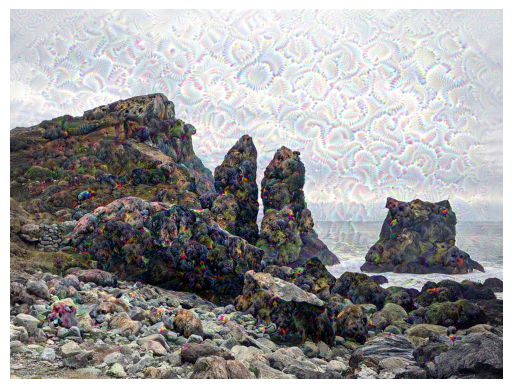

In [60]:
plt.axis('off')
plt.imshow(deprocess_image(img.numpy()))

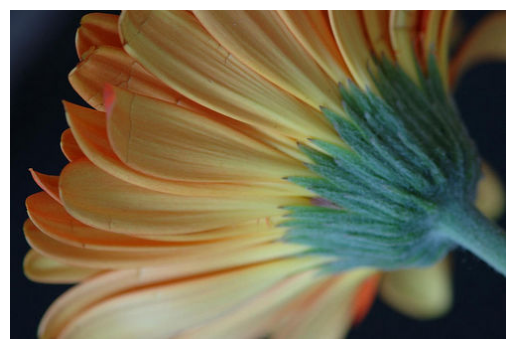

In [61]:
flowers_image_path = tf.keras.utils.get_file(
    fname="flower_photos.tgz",
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    extract=True,
    cache_dir='./'
)

base_image_path = './datasets/flower_photos/daisy/5673728_71b8cb57eb.jpg'

plt.axis('off')
plt.imshow(keras.utils.load_img(base_image_path))

0 (230, 347)
... Loss value at step 0: 1.16
... Loss value at step 1: 1.45
... Loss value at step 2: 1.77
... Loss value at step 3: 2.17
... Loss value at step 4: 2.61
... Loss value at step 5: 3.12
... Loss value at step 6: 3.58
... Loss value at step 7: 4.13
... Loss value at step 8: 4.72
... Loss value at step 9: 5.27
... Loss value at step 10: 5.85
... Loss value at step 11: 6.40
... Loss value at step 12: 7.02
... Loss value at step 13: 7.65
... Loss value at step 14: 8.33
... Loss value at step 15: 8.85
... Loss value at step 16: 9.54
... Loss value at step 17: 10.18
... Loss value at step 18: 10.86
... Loss value at step 19: 11.35
... Loss value at step 20: 12.03
... Loss value at step 21: 12.58
... Loss value at step 22: 13.21
... Loss value at step 23: 13.72
... Loss value at step 24: 14.32
... Loss value at step 25: 14.78
1 (276, 416)
... Loss value at step 0: 3.64
... Loss value at step 1: 5.89
... Loss value at step 2: 7.34
... Loss value at step 3: 8.37
... Loss value at s

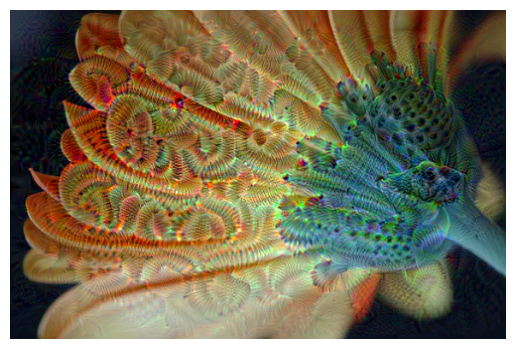

In [62]:
layer_settings = {
    'mixed4': 2.0,
    'mixed5': 2.5, 
    'mixed6': 1.0,
    'mixed7': 1.5
}

outputs_dict = dict ([
    (layer.name, layer.output) for layer in [model.get_layer(name) for name in layer_settings.keys()]
])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

step = 10.
num_octave = 3
octave_scale = 1.2
iterations = 30
max_loss = 15.

original_image = preprocess_image(base_image_path)
original_shape = original_image.shape[1:3]

succesive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    succesive_shapes.append(shape)

succesive_shapes = succesive_shapes[::-1]

shrunk_original_image = tf.image.resize(original_image, succesive_shapes[0])

img = tf.identity(original_image)
for i, shape in enumerate(succesive_shapes):
    print(i, shape)
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_image, shape)
    same_size_original = tf.image.resize(original_image, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_image = tf.image.resize(original_image, shape)

keras.utils.save_img('dream_2.jpg', deprocess_image(img.numpy()))

plt.axis('off')
plt.imshow(deprocess_image(img.numpy()))

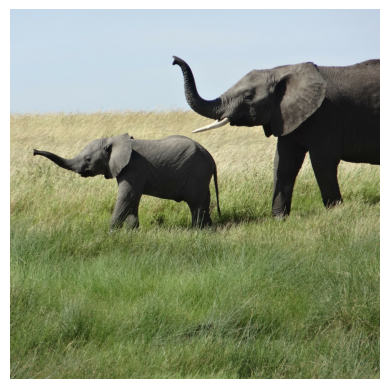

In [63]:
base_image_path = keras.utils.get_file('./elephant.jpg', 'https://img-datasets.s3.amazonaws.com/elephant.jpg')

plt.axis('off')
plt.imshow(keras.utils.load_img(base_image_path))

0 (833, 833)
... Loss value at step 0: 0.84
... Loss value at step 1: 1.06
... Loss value at step 2: 1.41
... Loss value at step 3: 1.82
... Loss value at step 4: 2.24
... Loss value at step 5: 2.68
... Loss value at step 6: 3.13
... Loss value at step 7: 3.57
... Loss value at step 8: 4.02
... Loss value at step 9: 4.44
... Loss value at step 10: 4.92
... Loss value at step 11: 5.41
... Loss value at step 12: 5.87
... Loss value at step 13: 6.43
... Loss value at step 14: 6.94
... Loss value at step 15: 7.48
... Loss value at step 16: 8.00
... Loss value at step 17: 8.55
... Loss value at step 18: 9.11
... Loss value at step 19: 9.71
... Loss value at step 20: 10.30
... Loss value at step 21: 10.88
... Loss value at step 22: 11.47
... Loss value at step 23: 12.07
... Loss value at step 24: 12.64
... Loss value at step 25: 13.20
... Loss value at step 26: 13.81
... Loss value at step 27: 14.43
... Loss value at step 28: 15.05
... Loss value at step 29: 15.61
1 (1000, 1000)
... Loss val

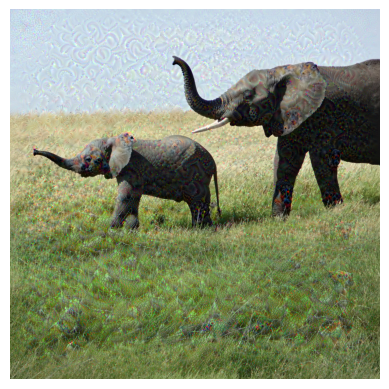

In [66]:
step = 20.
num_octave = 4
octave_scale = 1.2
iterations = 30
max_loss = 20.

original_image = preprocess_image(base_image_path)
original_shape = original_image.shape[1:3]

succesive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    succesive_shapes.append(shape)

succesive_shapes = succesive_shapes[::-1]

shrunk_original_image = tf.image.resize(original_image, succesive_shapes[0])

img = tf.identity(original_image)
for i, shape in enumerate(succesive_shapes):
    print(i, shape)
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_image, shape)
    same_size_original = tf.image.resize(original_image, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_image = tf.image.resize(original_image, shape)

keras.utils.save_img('dream_3.jpg', deprocess_image(img.numpy()))

plt.axis('off')
plt.imshow(deprocess_image(img.numpy()))

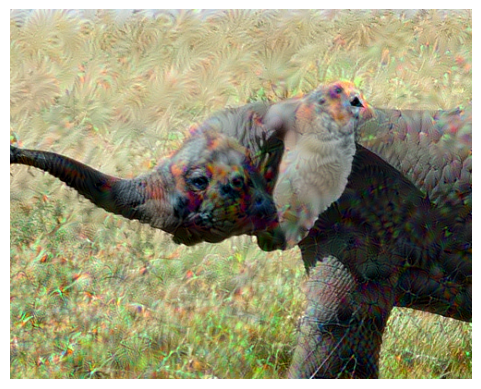

In [67]:
plt.axis('off')
plt.imshow(deprocess_image(img[:, 400:800, 100:600, :].numpy()))